In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import os
from pathlib import Path
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import imageio

from sklearn.model_selection import train_test_split
from pathlib import Path
import random

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
import importlib
try: 
    importlib.reload(utils)
    importlib.reload(generators)
    importlib.reload(trainers)
    print("libs reloaded")
except:
    import utils  
    import generators 
    import trainers
    print("libs imported")
  
#Prostate2D = utils.Prostate2D
VAE = generators.VAE
VAEGAN = generators.VAEGAN
TrainerVAE = trainers.TrainerVAE
TrainerVAEGAN = trainers.TrainerVAEGAN

libs imported


In [13]:
WORKING_DIR = Path(r"C:\Users\20182371\Documents\TUe\8DM20_CS_Medical_Imaging\DeepLearning_Project")
DATA_DIR = WORKING_DIR / "TrainingData"
PROGRESS_DIR_VAE = WORKING_DIR / "progress_vae"
PROGRESS_DIR_VAE.mkdir(parents=True, exist_ok=True)

PROGRESS_DIR_VAEGAN = WORKING_DIR / "progress_vaegan"
PROGRESS_DIR_VAEGAN.mkdir(parents=True, exist_ok=True)

Z_DIM = 256
BATCH_SIZE = 32
N_EPOCHS = 200
DECAY_LR_AFTER = 150 #50
LEARNING_RATE = 1e-3
OPTIMIZER = lambda parameters, lr : torch.optim.Adam(parameters, lr=lr, betas=(0.,0.9))
KLD_ANNEALING_EPOCHS = 50
GAMMA = 1.0
ADA_TARGET = 0.6
ADA_LENGTH = 10_000
ACCUM = 0.5 ** (32 / (10 * 1000))
NO_VALIDATION_PATIENTS = 2
IMAGE_SIZE = (64,64)
TOLERANCE = -1e-8
MINIMUM_VALID_LOSS = 10 

exp = str(N_EPOCHS) + '_epochs_' + str(Z_DIM) + "_zdim" + "_ema"
EXPERIMENT_DIR_VAE = PROGRESS_DIR_VAE / exp
EXPERIMENT_DIR_VAE.mkdir(parents=True, exist_ok=True)
EXPERIMENT_DIR_VAEGAN = PROGRESS_DIR_VAEGAN / exp
EXPERIMENT_DIR_VAEGAN.mkdir(parents=True, exist_ok=True)

def lambda_lr(the_epoch):
    return (
        1.0
        if the_epoch < DECAY_LR_AFTER
        else 1 - float(the_epoch - DECAY_LR_AFTER) / (N_EPOCHS - DECAY_LR_AFTER)
    )

patients = [
    path
    for path in DATA_DIR.glob("*")
    if not any(part.startswith(".") for part in path.parts)
]

train_indx, valid_indx = train_test_split(patients, random_state=seed, train_size=train_size)

# load training data and create DataLoader with batching and shuffling
train_set = utils.ProstateMRDataset(partition["train"], IMAGE_SIZE)
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

# load validation data
valid_set = utils.ProstateMRDataset(partition["validation"], IMAGE_SIZE)
valid_loader = DataLoader(
    valid_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

In [12]:
vae_model = VAE(z_dim=Z_DIM, spade=True).to(device)
optimizer = OPTIMIZER(vae_model.parameters(), lr=LEARNING_RATE)
vae_trainer = TrainerVAE(
    vae_model,
    optimizer,
    KLD_ANNEALING_EPOCHS,
    EXPERIMENT_DIR_VAE,
    train_loader,
    valid_loader,
    EXPERIMENT_DIR_VAE,
    TOLERANCE,
    MINIMUM_VALID_LOSS,
    device,
    seed = 0,
)
     

In [7]:
vae_trainer.train(N_EPOCHS, lambda_lr=lambda_lr)

  0%|          | 0/34 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plt.plot(range(1,N_EPOCHS+1), vae_trainer.train_losses)
plt.plot(range(1,N_EPOCHS+1), vae_trainer.valid_losses)
plt.xlabel('Number of epochs')
plt.ylabel('Reconstruction loss')
plt.title('Reconstruction loss mask vae')
plt.legend(['Training set', 'Validation set'])
plot_name = 'RECON_LOSS_'+str(N_EPOCHS) + '_epochs_' + str(Z_DIM) + '_zdim.png'
path = EXPERIMENT_DIR_VAEGAN / plot_name

plt.savefig(path, dpi=200)

In [4]:
OPTIMIZER = lambda parameters, lr : torch.optim.RMSprop(
    parameters,
    lr=lr,
    alpha=0.9,
    eps=1e-8,
    weight_decay=0,
    momentum=0,
    centered=False
)

vaegan_model = VAEGAN(z_dim=Z_DIM, l=2, spade=True).to(device)
net_ema = VAEGAN(z_dim=Z_DIM, l=2, spade=True).to(device)
net_ema.eval()

optimizer_enc = OPTIMIZER(vaegan_model.encoder.parameters(), lr=LEARNING_RATE)
optimizer_gen = OPTIMIZER(vaegan_model.generator.parameters(), lr=LEARNING_RATE)
optimizer_disc = OPTIMIZER(vaegan_model.discriminator.parameters(), lr=LEARNING_RATE)

vaegan_trainer = TrainerVAEGAN(
    vaegan_model,
    optimizer_enc,
    optimizer_gen,
    optimizer_disc,
    KLD_ANNEALING_EPOCHS,
    EXPERIMENT_DIR_VAEGAN,
    train_loader,
    valid_loader,
    EXPERIMENT_DIR_VAEGAN,
    TOLERANCE, 
    MINIMUM_VALID_LOSS,
    net_ema = net_ema,
    accum = ACCUM,
    ada_target = ADA_TARGET,
    ada_length = ADA_LENGTH,
    gamma = GAMMA,
    device = device,
    seed = 0,
)

In [5]:
vaegan_trainer.train(N_EPOCHS, lambda_lr=None)

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #000: Rec_Loss/train = 0.675, KLD/train = 10.416, Discl_Loss/train = 1.695, Adv_Loss/train = 1.052 | Rec_Loss/valid = 0.753, KLD/valid = 8.903, Discl_Loss/valid = 1.594, Adv_Loss/valid = 0.061


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #001: Rec_Loss/train = 0.654, KLD/train = 6.821, Discl_Loss/train = 1.464, Adv_Loss/train = 0.288 | Rec_Loss/valid = 0.533, KLD/valid = 4.486, Discl_Loss/valid = 1.590, Adv_Loss/valid = 0.077


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #002: Rec_Loss/train = 0.534, KLD/train = 5.065, Discl_Loss/train = 1.402, Adv_Loss/train = 0.343 | Rec_Loss/valid = 0.448, KLD/valid = 3.214, Discl_Loss/valid = 1.522, Adv_Loss/valid = 0.268


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #003: Rec_Loss/train = 0.506, KLD/train = 4.282, Discl_Loss/train = 1.522, Adv_Loss/train = 0.449 | Rec_Loss/valid = 0.442, KLD/valid = 3.644, Discl_Loss/valid = 1.670, Adv_Loss/valid = 0.572


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #004: Rec_Loss/train = 0.435, KLD/train = 3.692, Discl_Loss/train = 1.477, Adv_Loss/train = 0.525 | Rec_Loss/valid = 0.430, KLD/valid = 2.797, Discl_Loss/valid = 1.563, Adv_Loss/valid = 0.145


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #005: Rec_Loss/train = 0.395, KLD/train = 3.506, Discl_Loss/train = 1.410, Adv_Loss/train = 0.558 | Rec_Loss/valid = 0.378, KLD/valid = 2.319, Discl_Loss/valid = 1.517, Adv_Loss/valid = 0.580


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #006: Rec_Loss/train = 0.361, KLD/train = 2.691, Discl_Loss/train = 1.330, Adv_Loss/train = 0.558 | Rec_Loss/valid = 0.580, KLD/valid = 2.231, Discl_Loss/valid = 1.709, Adv_Loss/valid = 0.281


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #007: Rec_Loss/train = 0.340, KLD/train = 2.242, Discl_Loss/train = 1.308, Adv_Loss/train = 0.454 | Rec_Loss/valid = 0.336, KLD/valid = 1.706, Discl_Loss/valid = 1.416, Adv_Loss/valid = 0.216


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #008: Rec_Loss/train = 0.340, KLD/train = 1.880, Discl_Loss/train = 1.305, Adv_Loss/train = 0.473 | Rec_Loss/valid = 0.365, KLD/valid = 1.522, Discl_Loss/valid = 1.530, Adv_Loss/valid = 0.280


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #009: Rec_Loss/train = 0.314, KLD/train = 1.704, Discl_Loss/train = 1.268, Adv_Loss/train = 0.433 | Rec_Loss/valid = 0.467, KLD/valid = 1.180, Discl_Loss/valid = 1.492, Adv_Loss/valid = 0.256


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #010: Rec_Loss/train = 0.346, KLD/train = 1.413, Discl_Loss/train = 1.233, Adv_Loss/train = 0.391 | Rec_Loss/valid = 0.333, KLD/valid = 0.938, Discl_Loss/valid = 1.426, Adv_Loss/valid = 0.415


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #011: Rec_Loss/train = 0.319, KLD/train = 1.191, Discl_Loss/train = 1.165, Adv_Loss/train = 0.390 | Rec_Loss/valid = 0.369, KLD/valid = 0.940, Discl_Loss/valid = 1.386, Adv_Loss/valid = 0.509


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #012: Rec_Loss/train = 0.324, KLD/train = 0.993, Discl_Loss/train = 1.212, Adv_Loss/train = 0.447 | Rec_Loss/valid = 0.357, KLD/valid = 0.755, Discl_Loss/valid = 1.481, Adv_Loss/valid = 0.286


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #013: Rec_Loss/train = 0.320, KLD/train = 0.781, Discl_Loss/train = 1.170, Adv_Loss/train = 0.409 | Rec_Loss/valid = 0.327, KLD/valid = 0.602, Discl_Loss/valid = 1.574, Adv_Loss/valid = 0.263


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #014: Rec_Loss/train = 0.325, KLD/train = 0.670, Discl_Loss/train = 1.171, Adv_Loss/train = 0.388 | Rec_Loss/valid = 0.380, KLD/valid = 0.506, Discl_Loss/valid = 1.484, Adv_Loss/valid = 0.472


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #015: Rec_Loss/train = 0.312, KLD/train = 0.570, Discl_Loss/train = 1.117, Adv_Loss/train = 0.401 | Rec_Loss/valid = 0.308, KLD/valid = 0.424, Discl_Loss/valid = 1.465, Adv_Loss/valid = 0.301


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #016: Rec_Loss/train = 0.315, KLD/train = 0.488, Discl_Loss/train = 1.099, Adv_Loss/train = 0.405 | Rec_Loss/valid = 0.328, KLD/valid = 0.368, Discl_Loss/valid = 1.429, Adv_Loss/valid = 0.328


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #017: Rec_Loss/train = 0.319, KLD/train = 0.431, Discl_Loss/train = 1.125, Adv_Loss/train = 0.381 | Rec_Loss/valid = 0.317, KLD/valid = 0.267, Discl_Loss/valid = 1.341, Adv_Loss/valid = 0.295


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #018: Rec_Loss/train = 0.329, KLD/train = 0.351, Discl_Loss/train = 1.100, Adv_Loss/train = 0.390 | Rec_Loss/valid = 0.320, KLD/valid = 0.275, Discl_Loss/valid = 1.403, Adv_Loss/valid = 0.217


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #019: Rec_Loss/train = 0.312, KLD/train = 0.327, Discl_Loss/train = 1.107, Adv_Loss/train = 0.411 | Rec_Loss/valid = 0.393, KLD/valid = 0.254, Discl_Loss/valid = 1.460, Adv_Loss/valid = 0.469


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #020: Rec_Loss/train = 0.314, KLD/train = 0.271, Discl_Loss/train = 1.108, Adv_Loss/train = 0.409 | Rec_Loss/valid = 0.361, KLD/valid = 0.196, Discl_Loss/valid = 1.397, Adv_Loss/valid = 0.836


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #021: Rec_Loss/train = 0.322, KLD/train = 0.242, Discl_Loss/train = 1.104, Adv_Loss/train = 0.437 | Rec_Loss/valid = 0.312, KLD/valid = 0.191, Discl_Loss/valid = 1.351, Adv_Loss/valid = 0.289


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #022: Rec_Loss/train = 0.321, KLD/train = 0.212, Discl_Loss/train = 1.086, Adv_Loss/train = 0.391 | Rec_Loss/valid = 0.296, KLD/valid = 0.148, Discl_Loss/valid = 1.342, Adv_Loss/valid = 0.229


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #023: Rec_Loss/train = 0.329, KLD/train = 0.174, Discl_Loss/train = 1.091, Adv_Loss/train = 0.423 | Rec_Loss/valid = 0.308, KLD/valid = 0.132, Discl_Loss/valid = 1.339, Adv_Loss/valid = 0.240


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #024: Rec_Loss/train = 0.323, KLD/train = 0.165, Discl_Loss/train = 1.094, Adv_Loss/train = 0.436 | Rec_Loss/valid = 0.298, KLD/valid = 0.098, Discl_Loss/valid = 1.434, Adv_Loss/valid = 0.394


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #025: Rec_Loss/train = 0.308, KLD/train = 0.151, Discl_Loss/train = 1.092, Adv_Loss/train = 0.364 | Rec_Loss/valid = 0.292, KLD/valid = 0.114, Discl_Loss/valid = 1.355, Adv_Loss/valid = 0.196


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #026: Rec_Loss/train = 0.317, KLD/train = 0.136, Discl_Loss/train = 1.077, Adv_Loss/train = 0.412 | Rec_Loss/valid = 0.455, KLD/valid = 0.096, Discl_Loss/valid = 1.473, Adv_Loss/valid = 0.816


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #027: Rec_Loss/train = 0.320, KLD/train = 0.128, Discl_Loss/train = 1.080, Adv_Loss/train = 0.377 | Rec_Loss/valid = 0.295, KLD/valid = 0.096, Discl_Loss/valid = 1.333, Adv_Loss/valid = 0.401


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #028: Rec_Loss/train = 0.309, KLD/train = 0.120, Discl_Loss/train = 1.061, Adv_Loss/train = 0.399 | Rec_Loss/valid = 0.327, KLD/valid = 0.100, Discl_Loss/valid = 1.354, Adv_Loss/valid = 0.588


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #029: Rec_Loss/train = 0.321, KLD/train = 0.107, Discl_Loss/train = 1.050, Adv_Loss/train = 0.376 | Rec_Loss/valid = 0.334, KLD/valid = 0.082, Discl_Loss/valid = 1.336, Adv_Loss/valid = 0.326


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #030: Rec_Loss/train = 0.329, KLD/train = 0.102, Discl_Loss/train = 1.077, Adv_Loss/train = 0.413 | Rec_Loss/valid = 0.325, KLD/valid = 0.062, Discl_Loss/valid = 1.410, Adv_Loss/valid = 0.468


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #031: Rec_Loss/train = 0.331, KLD/train = 0.101, Discl_Loss/train = 1.073, Adv_Loss/train = 0.437 | Rec_Loss/valid = 0.335, KLD/valid = 0.074, Discl_Loss/valid = 1.319, Adv_Loss/valid = 0.289


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #032: Rec_Loss/train = 0.322, KLD/train = 0.098, Discl_Loss/train = 1.052, Adv_Loss/train = 0.395 | Rec_Loss/valid = 0.301, KLD/valid = 0.071, Discl_Loss/valid = 1.368, Adv_Loss/valid = 0.252


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #033: Rec_Loss/train = 0.328, KLD/train = 0.100, Discl_Loss/train = 1.065, Adv_Loss/train = 0.415 | Rec_Loss/valid = 0.302, KLD/valid = 0.066, Discl_Loss/valid = 1.347, Adv_Loss/valid = 0.508


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #034: Rec_Loss/train = 0.314, KLD/train = 0.095, Discl_Loss/train = 1.048, Adv_Loss/train = 0.411 | Rec_Loss/valid = 0.313, KLD/valid = 0.066, Discl_Loss/valid = 1.367, Adv_Loss/valid = 0.301


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #035: Rec_Loss/train = 0.304, KLD/train = 0.095, Discl_Loss/train = 1.037, Adv_Loss/train = 0.367 | Rec_Loss/valid = 0.392, KLD/valid = 0.056, Discl_Loss/valid = 1.412, Adv_Loss/valid = 0.689


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #036: Rec_Loss/train = 0.316, KLD/train = 0.090, Discl_Loss/train = 1.039, Adv_Loss/train = 0.404 | Rec_Loss/valid = 0.309, KLD/valid = 0.081, Discl_Loss/valid = 1.292, Adv_Loss/valid = 0.266


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #037: Rec_Loss/train = 0.327, KLD/train = 0.091, Discl_Loss/train = 1.038, Adv_Loss/train = 0.419 | Rec_Loss/valid = 0.330, KLD/valid = 0.058, Discl_Loss/valid = 1.354, Adv_Loss/valid = 0.875


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #038: Rec_Loss/train = 0.318, KLD/train = 0.086, Discl_Loss/train = 1.027, Adv_Loss/train = 0.382 | Rec_Loss/valid = 0.327, KLD/valid = 0.073, Discl_Loss/valid = 1.330, Adv_Loss/valid = 0.667


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #039: Rec_Loss/train = 0.320, KLD/train = 0.089, Discl_Loss/train = 1.045, Adv_Loss/train = 0.404 | Rec_Loss/valid = 0.309, KLD/valid = 0.064, Discl_Loss/valid = 1.302, Adv_Loss/valid = 0.652


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #040: Rec_Loss/train = 0.320, KLD/train = 0.087, Discl_Loss/train = 1.043, Adv_Loss/train = 0.449 | Rec_Loss/valid = 0.317, KLD/valid = 0.067, Discl_Loss/valid = 1.368, Adv_Loss/valid = 0.475


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #041: Rec_Loss/train = 0.321, KLD/train = 0.086, Discl_Loss/train = 1.003, Adv_Loss/train = 0.396 | Rec_Loss/valid = 0.300, KLD/valid = 0.062, Discl_Loss/valid = 1.256, Adv_Loss/valid = 0.224


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #042: Rec_Loss/train = 0.318, KLD/train = 0.084, Discl_Loss/train = 1.001, Adv_Loss/train = 0.411 | Rec_Loss/valid = 0.315, KLD/valid = 0.059, Discl_Loss/valid = 1.251, Adv_Loss/valid = 0.256


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #043: Rec_Loss/train = 0.314, KLD/train = 0.083, Discl_Loss/train = 0.993, Adv_Loss/train = 0.404 | Rec_Loss/valid = 0.297, KLD/valid = 0.056, Discl_Loss/valid = 1.258, Adv_Loss/valid = 0.154


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #044: Rec_Loss/train = 0.306, KLD/train = 0.084, Discl_Loss/train = 0.992, Adv_Loss/train = 0.355 | Rec_Loss/valid = 0.314, KLD/valid = 0.072, Discl_Loss/valid = 1.331, Adv_Loss/valid = 0.610


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #045: Rec_Loss/train = 0.316, KLD/train = 0.085, Discl_Loss/train = 1.010, Adv_Loss/train = 0.345 | Rec_Loss/valid = 0.326, KLD/valid = 0.048, Discl_Loss/valid = 1.296, Adv_Loss/valid = 0.643


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #046: Rec_Loss/train = 0.317, KLD/train = 0.084, Discl_Loss/train = 1.021, Adv_Loss/train = 0.383 | Rec_Loss/valid = 0.307, KLD/valid = 0.052, Discl_Loss/valid = 1.298, Adv_Loss/valid = 0.524


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #047: Rec_Loss/train = 0.311, KLD/train = 0.082, Discl_Loss/train = 0.984, Adv_Loss/train = 0.384 | Rec_Loss/valid = 0.308, KLD/valid = 0.056, Discl_Loss/valid = 1.351, Adv_Loss/valid = 0.551


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #048: Rec_Loss/train = 0.320, KLD/train = 0.083, Discl_Loss/train = 0.996, Adv_Loss/train = 0.366 | Rec_Loss/valid = 0.324, KLD/valid = 0.056, Discl_Loss/valid = 1.278, Adv_Loss/valid = 1.093


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #049: Rec_Loss/train = 0.310, KLD/train = 0.081, Discl_Loss/train = 0.999, Adv_Loss/train = 0.379 | Rec_Loss/valid = 0.338, KLD/valid = 0.048, Discl_Loss/valid = 1.305, Adv_Loss/valid = 0.655


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #050: Rec_Loss/train = 0.309, KLD/train = 0.081, Discl_Loss/train = 0.967, Adv_Loss/train = 0.362 | Rec_Loss/valid = 0.309, KLD/valid = 0.051, Discl_Loss/valid = 1.267, Adv_Loss/valid = 0.415


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #051: Rec_Loss/train = 0.316, KLD/train = 0.080, Discl_Loss/train = 0.968, Adv_Loss/train = 0.378 | Rec_Loss/valid = 0.312, KLD/valid = 0.067, Discl_Loss/valid = 1.282, Adv_Loss/valid = 0.619


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #052: Rec_Loss/train = 0.326, KLD/train = 0.084, Discl_Loss/train = 0.963, Adv_Loss/train = 0.361 | Rec_Loss/valid = 0.300, KLD/valid = 0.065, Discl_Loss/valid = 1.320, Adv_Loss/valid = 0.350


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #053: Rec_Loss/train = 0.307, KLD/train = 0.085, Discl_Loss/train = 0.964, Adv_Loss/train = 0.402 | Rec_Loss/valid = 0.312, KLD/valid = 0.050, Discl_Loss/valid = 1.281, Adv_Loss/valid = 0.429


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #054: Rec_Loss/train = 0.314, KLD/train = 0.082, Discl_Loss/train = 0.958, Adv_Loss/train = 0.405 | Rec_Loss/valid = 0.310, KLD/valid = 0.056, Discl_Loss/valid = 1.291, Adv_Loss/valid = 0.506


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #055: Rec_Loss/train = 0.314, KLD/train = 0.082, Discl_Loss/train = 0.972, Adv_Loss/train = 0.408 | Rec_Loss/valid = 0.310, KLD/valid = 0.052, Discl_Loss/valid = 1.283, Adv_Loss/valid = 0.512


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #056: Rec_Loss/train = 0.307, KLD/train = 0.082, Discl_Loss/train = 0.953, Adv_Loss/train = 0.385 | Rec_Loss/valid = 0.316, KLD/valid = 0.059, Discl_Loss/valid = 1.303, Adv_Loss/valid = 0.296


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #057: Rec_Loss/train = 0.320, KLD/train = 0.086, Discl_Loss/train = 0.964, Adv_Loss/train = 0.413 | Rec_Loss/valid = 0.313, KLD/valid = 0.071, Discl_Loss/valid = 1.296, Adv_Loss/valid = 0.447


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #058: Rec_Loss/train = 0.314, KLD/train = 0.083, Discl_Loss/train = 0.934, Adv_Loss/train = 0.372 | Rec_Loss/valid = 0.346, KLD/valid = 0.048, Discl_Loss/valid = 1.308, Adv_Loss/valid = 0.258


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #059: Rec_Loss/train = 0.322, KLD/train = 0.084, Discl_Loss/train = 0.965, Adv_Loss/train = 0.398 | Rec_Loss/valid = 0.310, KLD/valid = 0.056, Discl_Loss/valid = 1.298, Adv_Loss/valid = 0.411


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #060: Rec_Loss/train = 0.307, KLD/train = 0.084, Discl_Loss/train = 0.965, Adv_Loss/train = 0.358 | Rec_Loss/valid = 0.321, KLD/valid = 0.055, Discl_Loss/valid = 1.296, Adv_Loss/valid = 0.319


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #061: Rec_Loss/train = 0.309, KLD/train = 0.085, Discl_Loss/train = 0.969, Adv_Loss/train = 0.376 | Rec_Loss/valid = 0.313, KLD/valid = 0.054, Discl_Loss/valid = 1.327, Adv_Loss/valid = 0.261


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #062: Rec_Loss/train = 0.309, KLD/train = 0.087, Discl_Loss/train = 0.957, Adv_Loss/train = 0.354 | Rec_Loss/valid = 0.340, KLD/valid = 0.054, Discl_Loss/valid = 1.302, Adv_Loss/valid = 0.550


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #063: Rec_Loss/train = 0.318, KLD/train = 0.084, Discl_Loss/train = 0.949, Adv_Loss/train = 0.409 | Rec_Loss/valid = 0.324, KLD/valid = 0.062, Discl_Loss/valid = 1.292, Adv_Loss/valid = 0.526


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #064: Rec_Loss/train = 0.307, KLD/train = 0.083, Discl_Loss/train = 0.952, Adv_Loss/train = 0.353 | Rec_Loss/valid = 0.313, KLD/valid = 0.054, Discl_Loss/valid = 1.307, Adv_Loss/valid = 0.991


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #065: Rec_Loss/train = 0.309, KLD/train = 0.084, Discl_Loss/train = 0.958, Adv_Loss/train = 0.398 | Rec_Loss/valid = 0.357, KLD/valid = 0.066, Discl_Loss/valid = 1.346, Adv_Loss/valid = 0.805


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #066: Rec_Loss/train = 0.318, KLD/train = 0.086, Discl_Loss/train = 0.945, Adv_Loss/train = 0.388 | Rec_Loss/valid = 0.332, KLD/valid = 0.060, Discl_Loss/valid = 1.286, Adv_Loss/valid = 0.413


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #067: Rec_Loss/train = 0.315, KLD/train = 0.083, Discl_Loss/train = 0.952, Adv_Loss/train = 0.371 | Rec_Loss/valid = 0.345, KLD/valid = 0.051, Discl_Loss/valid = 1.351, Adv_Loss/valid = 1.234


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #068: Rec_Loss/train = 0.313, KLD/train = 0.083, Discl_Loss/train = 0.960, Adv_Loss/train = 0.393 | Rec_Loss/valid = 0.320, KLD/valid = 0.052, Discl_Loss/valid = 1.312, Adv_Loss/valid = 0.591


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #069: Rec_Loss/train = 0.309, KLD/train = 0.084, Discl_Loss/train = 0.960, Adv_Loss/train = 0.370 | Rec_Loss/valid = 0.317, KLD/valid = 0.052, Discl_Loss/valid = 1.322, Adv_Loss/valid = 1.081


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #070: Rec_Loss/train = 0.319, KLD/train = 0.083, Discl_Loss/train = 0.956, Adv_Loss/train = 0.382 | Rec_Loss/valid = 0.329, KLD/valid = 0.055, Discl_Loss/valid = 1.267, Adv_Loss/valid = 0.869


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #071: Rec_Loss/train = 0.308, KLD/train = 0.083, Discl_Loss/train = 0.927, Adv_Loss/train = 0.349 | Rec_Loss/valid = 0.316, KLD/valid = 0.066, Discl_Loss/valid = 1.287, Adv_Loss/valid = 0.490


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #072: Rec_Loss/train = 0.314, KLD/train = 0.085, Discl_Loss/train = 0.952, Adv_Loss/train = 0.400 | Rec_Loss/valid = 0.323, KLD/valid = 0.062, Discl_Loss/valid = 1.287, Adv_Loss/valid = 0.553


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #073: Rec_Loss/train = 0.311, KLD/train = 0.087, Discl_Loss/train = 0.946, Adv_Loss/train = 0.367 | Rec_Loss/valid = 0.317, KLD/valid = 0.050, Discl_Loss/valid = 1.284, Adv_Loss/valid = 0.543


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #074: Rec_Loss/train = 0.323, KLD/train = 0.083, Discl_Loss/train = 0.928, Adv_Loss/train = 0.389 | Rec_Loss/valid = 0.328, KLD/valid = 0.057, Discl_Loss/valid = 1.282, Adv_Loss/valid = 0.403


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #075: Rec_Loss/train = 0.312, KLD/train = 0.081, Discl_Loss/train = 0.922, Adv_Loss/train = 0.405 | Rec_Loss/valid = 0.325, KLD/valid = 0.050, Discl_Loss/valid = 1.289, Adv_Loss/valid = 0.417


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #076: Rec_Loss/train = 0.323, KLD/train = 0.084, Discl_Loss/train = 0.918, Adv_Loss/train = 0.396 | Rec_Loss/valid = 0.336, KLD/valid = 0.056, Discl_Loss/valid = 1.249, Adv_Loss/valid = 0.381


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #077: Rec_Loss/train = 0.308, KLD/train = 0.085, Discl_Loss/train = 0.911, Adv_Loss/train = 0.361 | Rec_Loss/valid = 0.306, KLD/valid = 0.060, Discl_Loss/valid = 1.311, Adv_Loss/valid = 0.810


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #078: Rec_Loss/train = 0.314, KLD/train = 0.083, Discl_Loss/train = 0.920, Adv_Loss/train = 0.391 | Rec_Loss/valid = 0.324, KLD/valid = 0.064, Discl_Loss/valid = 1.311, Adv_Loss/valid = 0.671


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #079: Rec_Loss/train = 0.311, KLD/train = 0.085, Discl_Loss/train = 0.908, Adv_Loss/train = 0.376 | Rec_Loss/valid = 0.328, KLD/valid = 0.061, Discl_Loss/valid = 1.278, Adv_Loss/valid = 0.830


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #080: Rec_Loss/train = 0.311, KLD/train = 0.086, Discl_Loss/train = 0.910, Adv_Loss/train = 0.385 | Rec_Loss/valid = 0.327, KLD/valid = 0.050, Discl_Loss/valid = 1.296, Adv_Loss/valid = 0.295


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #081: Rec_Loss/train = 0.320, KLD/train = 0.085, Discl_Loss/train = 0.911, Adv_Loss/train = 0.399 | Rec_Loss/valid = 0.332, KLD/valid = 0.056, Discl_Loss/valid = 1.292, Adv_Loss/valid = 0.540


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #082: Rec_Loss/train = 0.317, KLD/train = 0.088, Discl_Loss/train = 0.910, Adv_Loss/train = 0.404 | Rec_Loss/valid = 0.307, KLD/valid = 0.054, Discl_Loss/valid = 1.306, Adv_Loss/valid = 0.450


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #083: Rec_Loss/train = 0.316, KLD/train = 0.087, Discl_Loss/train = 0.913, Adv_Loss/train = 0.418 | Rec_Loss/valid = 0.307, KLD/valid = 0.051, Discl_Loss/valid = 1.306, Adv_Loss/valid = 0.663


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #084: Rec_Loss/train = 0.305, KLD/train = 0.086, Discl_Loss/train = 0.889, Adv_Loss/train = 0.393 | Rec_Loss/valid = 0.326, KLD/valid = 0.053, Discl_Loss/valid = 1.280, Adv_Loss/valid = 0.454


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #085: Rec_Loss/train = 0.321, KLD/train = 0.085, Discl_Loss/train = 0.896, Adv_Loss/train = 0.429 | Rec_Loss/valid = 0.312, KLD/valid = 0.055, Discl_Loss/valid = 1.275, Adv_Loss/valid = 1.331


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #086: Rec_Loss/train = 0.304, KLD/train = 0.084, Discl_Loss/train = 0.896, Adv_Loss/train = 0.397 | Rec_Loss/valid = 0.313, KLD/valid = 0.063, Discl_Loss/valid = 1.334, Adv_Loss/valid = 0.398


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #087: Rec_Loss/train = 0.305, KLD/train = 0.085, Discl_Loss/train = 0.903, Adv_Loss/train = 0.404 | Rec_Loss/valid = 0.314, KLD/valid = 0.063, Discl_Loss/valid = 1.259, Adv_Loss/valid = 0.472


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #088: Rec_Loss/train = 0.312, KLD/train = 0.087, Discl_Loss/train = 0.892, Adv_Loss/train = 0.428 | Rec_Loss/valid = 0.318, KLD/valid = 0.060, Discl_Loss/valid = 1.276, Adv_Loss/valid = 0.835


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #089: Rec_Loss/train = 0.311, KLD/train = 0.083, Discl_Loss/train = 0.890, Adv_Loss/train = 0.373 | Rec_Loss/valid = 0.327, KLD/valid = 0.054, Discl_Loss/valid = 1.325, Adv_Loss/valid = 0.426


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #090: Rec_Loss/train = 0.311, KLD/train = 0.084, Discl_Loss/train = 0.891, Adv_Loss/train = 0.369 | Rec_Loss/valid = 0.331, KLD/valid = 0.051, Discl_Loss/valid = 1.273, Adv_Loss/valid = 0.626


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #091: Rec_Loss/train = 0.305, KLD/train = 0.083, Discl_Loss/train = 0.894, Adv_Loss/train = 0.384 | Rec_Loss/valid = 0.330, KLD/valid = 0.054, Discl_Loss/valid = 1.276, Adv_Loss/valid = 0.831


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #092: Rec_Loss/train = 0.311, KLD/train = 0.086, Discl_Loss/train = 0.870, Adv_Loss/train = 0.401 | Rec_Loss/valid = 0.337, KLD/valid = 0.064, Discl_Loss/valid = 1.273, Adv_Loss/valid = 1.207


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #093: Rec_Loss/train = 0.300, KLD/train = 0.085, Discl_Loss/train = 0.911, Adv_Loss/train = 0.405 | Rec_Loss/valid = 0.318, KLD/valid = 0.061, Discl_Loss/valid = 1.287, Adv_Loss/valid = 0.533


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #094: Rec_Loss/train = 0.303, KLD/train = 0.087, Discl_Loss/train = 0.904, Adv_Loss/train = 0.409 | Rec_Loss/valid = 0.327, KLD/valid = 0.054, Discl_Loss/valid = 1.265, Adv_Loss/valid = 1.020


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #095: Rec_Loss/train = 0.301, KLD/train = 0.088, Discl_Loss/train = 0.869, Adv_Loss/train = 0.410 | Rec_Loss/valid = 0.316, KLD/valid = 0.052, Discl_Loss/valid = 1.246, Adv_Loss/valid = 1.292


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #096: Rec_Loss/train = 0.294, KLD/train = 0.084, Discl_Loss/train = 0.854, Adv_Loss/train = 0.331 | Rec_Loss/valid = 0.324, KLD/valid = 0.055, Discl_Loss/valid = 1.226, Adv_Loss/valid = 0.498


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #097: Rec_Loss/train = 0.312, KLD/train = 0.084, Discl_Loss/train = 0.861, Adv_Loss/train = 0.398 | Rec_Loss/valid = 0.315, KLD/valid = 0.053, Discl_Loss/valid = 1.243, Adv_Loss/valid = 0.641


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #098: Rec_Loss/train = 0.308, KLD/train = 0.085, Discl_Loss/train = 0.860, Adv_Loss/train = 0.392 | Rec_Loss/valid = 0.311, KLD/valid = 0.052, Discl_Loss/valid = 1.249, Adv_Loss/valid = 0.936


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #099: Rec_Loss/train = 0.300, KLD/train = 0.083, Discl_Loss/train = 0.849, Adv_Loss/train = 0.402 | Rec_Loss/valid = 0.323, KLD/valid = 0.058, Discl_Loss/valid = 1.261, Adv_Loss/valid = 1.322


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #100: Rec_Loss/train = 0.302, KLD/train = 0.082, Discl_Loss/train = 0.848, Adv_Loss/train = 0.374 | Rec_Loss/valid = 0.372, KLD/valid = 0.058, Discl_Loss/valid = 1.280, Adv_Loss/valid = 0.319


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #101: Rec_Loss/train = 0.310, KLD/train = 0.084, Discl_Loss/train = 0.859, Adv_Loss/train = 0.403 | Rec_Loss/valid = 0.304, KLD/valid = 0.055, Discl_Loss/valid = 1.228, Adv_Loss/valid = 0.378


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #102: Rec_Loss/train = 0.313, KLD/train = 0.085, Discl_Loss/train = 0.848, Adv_Loss/train = 0.422 | Rec_Loss/valid = 0.310, KLD/valid = 0.060, Discl_Loss/valid = 1.200, Adv_Loss/valid = 0.372


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #103: Rec_Loss/train = 0.305, KLD/train = 0.086, Discl_Loss/train = 0.860, Adv_Loss/train = 0.418 | Rec_Loss/valid = 0.318, KLD/valid = 0.060, Discl_Loss/valid = 1.261, Adv_Loss/valid = 0.809


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #104: Rec_Loss/train = 0.301, KLD/train = 0.086, Discl_Loss/train = 0.864, Adv_Loss/train = 0.397 | Rec_Loss/valid = 0.325, KLD/valid = 0.055, Discl_Loss/valid = 1.276, Adv_Loss/valid = 0.434


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #105: Rec_Loss/train = 0.296, KLD/train = 0.085, Discl_Loss/train = 0.848, Adv_Loss/train = 0.332 | Rec_Loss/valid = 0.335, KLD/valid = 0.058, Discl_Loss/valid = 1.268, Adv_Loss/valid = 0.247


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #106: Rec_Loss/train = 0.307, KLD/train = 0.087, Discl_Loss/train = 0.874, Adv_Loss/train = 0.369 | Rec_Loss/valid = 0.310, KLD/valid = 0.055, Discl_Loss/valid = 1.201, Adv_Loss/valid = 1.165


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #107: Rec_Loss/train = 0.307, KLD/train = 0.084, Discl_Loss/train = 0.851, Adv_Loss/train = 0.403 | Rec_Loss/valid = 0.312, KLD/valid = 0.050, Discl_Loss/valid = 1.246, Adv_Loss/valid = 0.265


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #108: Rec_Loss/train = 0.307, KLD/train = 0.082, Discl_Loss/train = 0.841, Adv_Loss/train = 0.400 | Rec_Loss/valid = 0.324, KLD/valid = 0.063, Discl_Loss/valid = 1.216, Adv_Loss/valid = 1.009


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #109: Rec_Loss/train = 0.298, KLD/train = 0.080, Discl_Loss/train = 0.831, Adv_Loss/train = 0.354 | Rec_Loss/valid = 0.314, KLD/valid = 0.059, Discl_Loss/valid = 1.191, Adv_Loss/valid = 0.602


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #110: Rec_Loss/train = 0.304, KLD/train = 0.086, Discl_Loss/train = 0.833, Adv_Loss/train = 0.412 | Rec_Loss/valid = 0.318, KLD/valid = 0.052, Discl_Loss/valid = 1.231, Adv_Loss/valid = 0.382


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #111: Rec_Loss/train = 0.304, KLD/train = 0.086, Discl_Loss/train = 0.830, Adv_Loss/train = 0.372 | Rec_Loss/valid = 0.304, KLD/valid = 0.060, Discl_Loss/valid = 1.238, Adv_Loss/valid = 0.657


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #112: Rec_Loss/train = 0.301, KLD/train = 0.084, Discl_Loss/train = 0.830, Adv_Loss/train = 0.387 | Rec_Loss/valid = 0.314, KLD/valid = 0.053, Discl_Loss/valid = 1.269, Adv_Loss/valid = 1.306


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #113: Rec_Loss/train = 0.302, KLD/train = 0.085, Discl_Loss/train = 0.826, Adv_Loss/train = 0.382 | Rec_Loss/valid = 0.343, KLD/valid = 0.055, Discl_Loss/valid = 1.279, Adv_Loss/valid = 0.811


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #114: Rec_Loss/train = 0.296, KLD/train = 0.087, Discl_Loss/train = 0.820, Adv_Loss/train = 0.362 | Rec_Loss/valid = 0.328, KLD/valid = 0.052, Discl_Loss/valid = 1.215, Adv_Loss/valid = 0.936


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #115: Rec_Loss/train = 0.300, KLD/train = 0.087, Discl_Loss/train = 0.835, Adv_Loss/train = 0.395 | Rec_Loss/valid = 0.306, KLD/valid = 0.058, Discl_Loss/valid = 1.257, Adv_Loss/valid = 0.504


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #116: Rec_Loss/train = 0.296, KLD/train = 0.084, Discl_Loss/train = 0.836, Adv_Loss/train = 0.367 | Rec_Loss/valid = 0.317, KLD/valid = 0.055, Discl_Loss/valid = 1.234, Adv_Loss/valid = 0.162


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #117: Rec_Loss/train = 0.304, KLD/train = 0.083, Discl_Loss/train = 0.828, Adv_Loss/train = 0.421 | Rec_Loss/valid = 0.317, KLD/valid = 0.060, Discl_Loss/valid = 1.288, Adv_Loss/valid = 0.785


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #118: Rec_Loss/train = 0.296, KLD/train = 0.085, Discl_Loss/train = 0.838, Adv_Loss/train = 0.374 | Rec_Loss/valid = 0.331, KLD/valid = 0.052, Discl_Loss/valid = 1.279, Adv_Loss/valid = 0.631


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #119: Rec_Loss/train = 0.295, KLD/train = 0.083, Discl_Loss/train = 0.813, Adv_Loss/train = 0.333 | Rec_Loss/valid = 0.320, KLD/valid = 0.053, Discl_Loss/valid = 1.270, Adv_Loss/valid = 0.614


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #120: Rec_Loss/train = 0.306, KLD/train = 0.082, Discl_Loss/train = 0.833, Adv_Loss/train = 0.400 | Rec_Loss/valid = 0.311, KLD/valid = 0.052, Discl_Loss/valid = 1.277, Adv_Loss/valid = 0.339


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #121: Rec_Loss/train = 0.309, KLD/train = 0.083, Discl_Loss/train = 0.840, Adv_Loss/train = 0.402 | Rec_Loss/valid = 0.333, KLD/valid = 0.058, Discl_Loss/valid = 1.275, Adv_Loss/valid = 0.590


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #122: Rec_Loss/train = 0.301, KLD/train = 0.084, Discl_Loss/train = 0.831, Adv_Loss/train = 0.393 | Rec_Loss/valid = 0.306, KLD/valid = 0.057, Discl_Loss/valid = 1.222, Adv_Loss/valid = 0.606


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #123: Rec_Loss/train = 0.306, KLD/train = 0.084, Discl_Loss/train = 0.829, Adv_Loss/train = 0.398 | Rec_Loss/valid = 0.332, KLD/valid = 0.059, Discl_Loss/valid = 1.289, Adv_Loss/valid = 0.528


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #124: Rec_Loss/train = 0.298, KLD/train = 0.083, Discl_Loss/train = 0.815, Adv_Loss/train = 0.335 | Rec_Loss/valid = 0.302, KLD/valid = 0.056, Discl_Loss/valid = 1.255, Adv_Loss/valid = 0.990


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #125: Rec_Loss/train = 0.301, KLD/train = 0.083, Discl_Loss/train = 0.810, Adv_Loss/train = 0.381 | Rec_Loss/valid = 0.326, KLD/valid = 0.054, Discl_Loss/valid = 1.254, Adv_Loss/valid = 0.691


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #126: Rec_Loss/train = 0.302, KLD/train = 0.083, Discl_Loss/train = 0.815, Adv_Loss/train = 0.368 | Rec_Loss/valid = 0.309, KLD/valid = 0.055, Discl_Loss/valid = 1.223, Adv_Loss/valid = 0.565


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #127: Rec_Loss/train = 0.308, KLD/train = 0.083, Discl_Loss/train = 0.814, Adv_Loss/train = 0.399 | Rec_Loss/valid = 0.311, KLD/valid = 0.059, Discl_Loss/valid = 1.225, Adv_Loss/valid = 0.286


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #128: Rec_Loss/train = 0.299, KLD/train = 0.084, Discl_Loss/train = 0.804, Adv_Loss/train = 0.370 | Rec_Loss/valid = 0.328, KLD/valid = 0.054, Discl_Loss/valid = 1.229, Adv_Loss/valid = 0.488


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #129: Rec_Loss/train = 0.298, KLD/train = 0.083, Discl_Loss/train = 0.793, Adv_Loss/train = 0.363 | Rec_Loss/valid = 0.316, KLD/valid = 0.056, Discl_Loss/valid = 1.213, Adv_Loss/valid = 0.954


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #130: Rec_Loss/train = 0.303, KLD/train = 0.083, Discl_Loss/train = 0.806, Adv_Loss/train = 0.396 | Rec_Loss/valid = 0.333, KLD/valid = 0.056, Discl_Loss/valid = 1.260, Adv_Loss/valid = 1.002


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #131: Rec_Loss/train = 0.298, KLD/train = 0.084, Discl_Loss/train = 0.809, Adv_Loss/train = 0.397 | Rec_Loss/valid = 0.300, KLD/valid = 0.053, Discl_Loss/valid = 1.243, Adv_Loss/valid = 0.412


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #132: Rec_Loss/train = 0.299, KLD/train = 0.082, Discl_Loss/train = 0.805, Adv_Loss/train = 0.385 | Rec_Loss/valid = 0.312, KLD/valid = 0.056, Discl_Loss/valid = 1.274, Adv_Loss/valid = 0.286


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #133: Rec_Loss/train = 0.298, KLD/train = 0.083, Discl_Loss/train = 0.803, Adv_Loss/train = 0.371 | Rec_Loss/valid = 0.303, KLD/valid = 0.059, Discl_Loss/valid = 1.268, Adv_Loss/valid = 0.586


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #134: Rec_Loss/train = 0.301, KLD/train = 0.083, Discl_Loss/train = 0.813, Adv_Loss/train = 0.392 | Rec_Loss/valid = 0.309, KLD/valid = 0.059, Discl_Loss/valid = 1.274, Adv_Loss/valid = 0.460


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #135: Rec_Loss/train = 0.305, KLD/train = 0.083, Discl_Loss/train = 0.815, Adv_Loss/train = 0.366 | Rec_Loss/valid = 0.301, KLD/valid = 0.055, Discl_Loss/valid = 1.256, Adv_Loss/valid = 1.602


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #136: Rec_Loss/train = 0.300, KLD/train = 0.082, Discl_Loss/train = 0.786, Adv_Loss/train = 0.399 | Rec_Loss/valid = 0.320, KLD/valid = 0.055, Discl_Loss/valid = 1.253, Adv_Loss/valid = 0.207


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #137: Rec_Loss/train = 0.298, KLD/train = 0.083, Discl_Loss/train = 0.804, Adv_Loss/train = 0.379 | Rec_Loss/valid = 0.316, KLD/valid = 0.055, Discl_Loss/valid = 1.264, Adv_Loss/valid = 0.895


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #138: Rec_Loss/train = 0.298, KLD/train = 0.082, Discl_Loss/train = 0.813, Adv_Loss/train = 0.368 | Rec_Loss/valid = 0.316, KLD/valid = 0.055, Discl_Loss/valid = 1.278, Adv_Loss/valid = 1.252


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #139: Rec_Loss/train = 0.297, KLD/train = 0.084, Discl_Loss/train = 0.793, Adv_Loss/train = 0.364 | Rec_Loss/valid = 0.314, KLD/valid = 0.052, Discl_Loss/valid = 1.250, Adv_Loss/valid = 0.542


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #140: Rec_Loss/train = 0.304, KLD/train = 0.084, Discl_Loss/train = 0.792, Adv_Loss/train = 0.399 | Rec_Loss/valid = 0.312, KLD/valid = 0.057, Discl_Loss/valid = 1.251, Adv_Loss/valid = 0.698


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #141: Rec_Loss/train = 0.298, KLD/train = 0.083, Discl_Loss/train = 0.799, Adv_Loss/train = 0.374 | Rec_Loss/valid = 0.327, KLD/valid = 0.050, Discl_Loss/valid = 1.271, Adv_Loss/valid = 0.482


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #142: Rec_Loss/train = 0.300, KLD/train = 0.083, Discl_Loss/train = 0.779, Adv_Loss/train = 0.368 | Rec_Loss/valid = 0.331, KLD/valid = 0.056, Discl_Loss/valid = 1.257, Adv_Loss/valid = 0.365


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #143: Rec_Loss/train = 0.301, KLD/train = 0.085, Discl_Loss/train = 0.777, Adv_Loss/train = 0.401 | Rec_Loss/valid = 0.319, KLD/valid = 0.052, Discl_Loss/valid = 1.253, Adv_Loss/valid = 0.305


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #144: Rec_Loss/train = 0.301, KLD/train = 0.081, Discl_Loss/train = 0.789, Adv_Loss/train = 0.367 | Rec_Loss/valid = 0.322, KLD/valid = 0.052, Discl_Loss/valid = 1.254, Adv_Loss/valid = 0.258


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #145: Rec_Loss/train = 0.289, KLD/train = 0.083, Discl_Loss/train = 0.787, Adv_Loss/train = 0.350 | Rec_Loss/valid = 0.327, KLD/valid = 0.053, Discl_Loss/valid = 1.247, Adv_Loss/valid = 0.412


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #146: Rec_Loss/train = 0.297, KLD/train = 0.082, Discl_Loss/train = 0.785, Adv_Loss/train = 0.373 | Rec_Loss/valid = 0.314, KLD/valid = 0.055, Discl_Loss/valid = 1.217, Adv_Loss/valid = 0.574


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #147: Rec_Loss/train = 0.286, KLD/train = 0.084, Discl_Loss/train = 0.785, Adv_Loss/train = 0.346 | Rec_Loss/valid = 0.314, KLD/valid = 0.055, Discl_Loss/valid = 1.232, Adv_Loss/valid = 0.388


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #148: Rec_Loss/train = 0.294, KLD/train = 0.083, Discl_Loss/train = 0.787, Adv_Loss/train = 0.362 | Rec_Loss/valid = 0.324, KLD/valid = 0.056, Discl_Loss/valid = 1.222, Adv_Loss/valid = 1.229


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #149: Rec_Loss/train = 0.299, KLD/train = 0.081, Discl_Loss/train = 0.785, Adv_Loss/train = 0.384 | Rec_Loss/valid = 0.333, KLD/valid = 0.053, Discl_Loss/valid = 1.266, Adv_Loss/valid = 0.908


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #150: Rec_Loss/train = 0.293, KLD/train = 0.083, Discl_Loss/train = 0.787, Adv_Loss/train = 0.367 | Rec_Loss/valid = 0.319, KLD/valid = 0.056, Discl_Loss/valid = 1.279, Adv_Loss/valid = 0.545


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #151: Rec_Loss/train = 0.305, KLD/train = 0.084, Discl_Loss/train = 0.786, Adv_Loss/train = 0.403 | Rec_Loss/valid = 0.333, KLD/valid = 0.060, Discl_Loss/valid = 1.224, Adv_Loss/valid = 0.623


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #152: Rec_Loss/train = 0.300, KLD/train = 0.082, Discl_Loss/train = 0.785, Adv_Loss/train = 0.383 | Rec_Loss/valid = 0.337, KLD/valid = 0.054, Discl_Loss/valid = 1.258, Adv_Loss/valid = 0.420


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #153: Rec_Loss/train = 0.296, KLD/train = 0.083, Discl_Loss/train = 0.788, Adv_Loss/train = 0.392 | Rec_Loss/valid = 0.321, KLD/valid = 0.059, Discl_Loss/valid = 1.270, Adv_Loss/valid = 0.429


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #154: Rec_Loss/train = 0.300, KLD/train = 0.083, Discl_Loss/train = 0.793, Adv_Loss/train = 0.408 | Rec_Loss/valid = 0.326, KLD/valid = 0.050, Discl_Loss/valid = 1.251, Adv_Loss/valid = 1.109


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #155: Rec_Loss/train = 0.302, KLD/train = 0.084, Discl_Loss/train = 0.791, Adv_Loss/train = 0.389 | Rec_Loss/valid = 0.320, KLD/valid = 0.049, Discl_Loss/valid = 1.229, Adv_Loss/valid = 1.371


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #156: Rec_Loss/train = 0.298, KLD/train = 0.082, Discl_Loss/train = 0.791, Adv_Loss/train = 0.379 | Rec_Loss/valid = 0.314, KLD/valid = 0.052, Discl_Loss/valid = 1.260, Adv_Loss/valid = 0.672


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #157: Rec_Loss/train = 0.303, KLD/train = 0.083, Discl_Loss/train = 0.779, Adv_Loss/train = 0.380 | Rec_Loss/valid = 0.330, KLD/valid = 0.052, Discl_Loss/valid = 1.279, Adv_Loss/valid = 0.899


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #158: Rec_Loss/train = 0.289, KLD/train = 0.084, Discl_Loss/train = 0.768, Adv_Loss/train = 0.360 | Rec_Loss/valid = 0.310, KLD/valid = 0.049, Discl_Loss/valid = 1.259, Adv_Loss/valid = 0.539


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #159: Rec_Loss/train = 0.290, KLD/train = 0.083, Discl_Loss/train = 0.767, Adv_Loss/train = 0.376 | Rec_Loss/valid = 0.306, KLD/valid = 0.051, Discl_Loss/valid = 1.253, Adv_Loss/valid = 0.736


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #160: Rec_Loss/train = 0.295, KLD/train = 0.083, Discl_Loss/train = 0.785, Adv_Loss/train = 0.405 | Rec_Loss/valid = 0.298, KLD/valid = 0.055, Discl_Loss/valid = 1.265, Adv_Loss/valid = 0.501


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #161: Rec_Loss/train = 0.292, KLD/train = 0.083, Discl_Loss/train = 0.783, Adv_Loss/train = 0.357 | Rec_Loss/valid = 0.326, KLD/valid = 0.053, Discl_Loss/valid = 1.270, Adv_Loss/valid = 0.992


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #162: Rec_Loss/train = 0.304, KLD/train = 0.084, Discl_Loss/train = 0.791, Adv_Loss/train = 0.407 | Rec_Loss/valid = 0.306, KLD/valid = 0.054, Discl_Loss/valid = 1.265, Adv_Loss/valid = 0.630


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #163: Rec_Loss/train = 0.305, KLD/train = 0.082, Discl_Loss/train = 0.791, Adv_Loss/train = 0.396 | Rec_Loss/valid = 0.319, KLD/valid = 0.054, Discl_Loss/valid = 1.258, Adv_Loss/valid = 1.112


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #164: Rec_Loss/train = 0.297, KLD/train = 0.082, Discl_Loss/train = 0.796, Adv_Loss/train = 0.381 | Rec_Loss/valid = 0.315, KLD/valid = 0.054, Discl_Loss/valid = 1.254, Adv_Loss/valid = 0.904


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #165: Rec_Loss/train = 0.296, KLD/train = 0.084, Discl_Loss/train = 0.787, Adv_Loss/train = 0.395 | Rec_Loss/valid = 0.306, KLD/valid = 0.052, Discl_Loss/valid = 1.266, Adv_Loss/valid = 0.757


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #166: Rec_Loss/train = 0.301, KLD/train = 0.083, Discl_Loss/train = 0.787, Adv_Loss/train = 0.388 | Rec_Loss/valid = 0.321, KLD/valid = 0.055, Discl_Loss/valid = 1.270, Adv_Loss/valid = 1.143


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #167: Rec_Loss/train = 0.307, KLD/train = 0.083, Discl_Loss/train = 0.791, Adv_Loss/train = 0.453 | Rec_Loss/valid = 0.309, KLD/valid = 0.052, Discl_Loss/valid = 1.255, Adv_Loss/valid = 0.754


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #168: Rec_Loss/train = 0.296, KLD/train = 0.081, Discl_Loss/train = 0.763, Adv_Loss/train = 0.367 | Rec_Loss/valid = 0.322, KLD/valid = 0.053, Discl_Loss/valid = 1.254, Adv_Loss/valid = 0.466


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #169: Rec_Loss/train = 0.302, KLD/train = 0.084, Discl_Loss/train = 0.768, Adv_Loss/train = 0.408 | Rec_Loss/valid = 0.311, KLD/valid = 0.049, Discl_Loss/valid = 1.246, Adv_Loss/valid = 1.305


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #170: Rec_Loss/train = 0.302, KLD/train = 0.080, Discl_Loss/train = 0.755, Adv_Loss/train = 0.392 | Rec_Loss/valid = 0.320, KLD/valid = 0.053, Discl_Loss/valid = 1.298, Adv_Loss/valid = 0.508


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #171: Rec_Loss/train = 0.297, KLD/train = 0.083, Discl_Loss/train = 0.759, Adv_Loss/train = 0.402 | Rec_Loss/valid = 0.320, KLD/valid = 0.056, Discl_Loss/valid = 1.246, Adv_Loss/valid = 0.756


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #172: Rec_Loss/train = 0.297, KLD/train = 0.082, Discl_Loss/train = 0.758, Adv_Loss/train = 0.382 | Rec_Loss/valid = 0.349, KLD/valid = 0.057, Discl_Loss/valid = 1.230, Adv_Loss/valid = 1.534


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #173: Rec_Loss/train = 0.304, KLD/train = 0.082, Discl_Loss/train = 0.765, Adv_Loss/train = 0.386 | Rec_Loss/valid = 0.309, KLD/valid = 0.054, Discl_Loss/valid = 1.270, Adv_Loss/valid = 0.905


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #174: Rec_Loss/train = 0.295, KLD/train = 0.083, Discl_Loss/train = 0.764, Adv_Loss/train = 0.367 | Rec_Loss/valid = 0.302, KLD/valid = 0.047, Discl_Loss/valid = 1.238, Adv_Loss/valid = 0.908


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #175: Rec_Loss/train = 0.302, KLD/train = 0.081, Discl_Loss/train = 0.765, Adv_Loss/train = 0.415 | Rec_Loss/valid = 0.313, KLD/valid = 0.047, Discl_Loss/valid = 1.258, Adv_Loss/valid = 0.862


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #176: Rec_Loss/train = 0.293, KLD/train = 0.081, Discl_Loss/train = 0.768, Adv_Loss/train = 0.370 | Rec_Loss/valid = 0.306, KLD/valid = 0.051, Discl_Loss/valid = 1.220, Adv_Loss/valid = 0.511


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #177: Rec_Loss/train = 0.293, KLD/train = 0.080, Discl_Loss/train = 0.758, Adv_Loss/train = 0.383 | Rec_Loss/valid = 0.319, KLD/valid = 0.046, Discl_Loss/valid = 1.221, Adv_Loss/valid = 1.085


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #178: Rec_Loss/train = 0.302, KLD/train = 0.081, Discl_Loss/train = 0.758, Adv_Loss/train = 0.401 | Rec_Loss/valid = 0.326, KLD/valid = 0.046, Discl_Loss/valid = 1.229, Adv_Loss/valid = 0.960


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #179: Rec_Loss/train = 0.298, KLD/train = 0.079, Discl_Loss/train = 0.759, Adv_Loss/train = 0.396 | Rec_Loss/valid = 0.325, KLD/valid = 0.047, Discl_Loss/valid = 1.255, Adv_Loss/valid = 0.575


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #180: Rec_Loss/train = 0.292, KLD/train = 0.079, Discl_Loss/train = 0.769, Adv_Loss/train = 0.376 | Rec_Loss/valid = 0.320, KLD/valid = 0.048, Discl_Loss/valid = 1.272, Adv_Loss/valid = 0.908


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #181: Rec_Loss/train = 0.298, KLD/train = 0.081, Discl_Loss/train = 0.762, Adv_Loss/train = 0.377 | Rec_Loss/valid = 0.312, KLD/valid = 0.052, Discl_Loss/valid = 1.249, Adv_Loss/valid = 0.882


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #182: Rec_Loss/train = 0.300, KLD/train = 0.083, Discl_Loss/train = 0.759, Adv_Loss/train = 0.406 | Rec_Loss/valid = 0.314, KLD/valid = 0.044, Discl_Loss/valid = 1.249, Adv_Loss/valid = 1.258


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #183: Rec_Loss/train = 0.295, KLD/train = 0.081, Discl_Loss/train = 0.747, Adv_Loss/train = 0.380 | Rec_Loss/valid = 0.305, KLD/valid = 0.054, Discl_Loss/valid = 1.233, Adv_Loss/valid = 1.201


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #184: Rec_Loss/train = 0.298, KLD/train = 0.081, Discl_Loss/train = 0.754, Adv_Loss/train = 0.398 | Rec_Loss/valid = 0.312, KLD/valid = 0.049, Discl_Loss/valid = 1.240, Adv_Loss/valid = 0.769


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #185: Rec_Loss/train = 0.301, KLD/train = 0.082, Discl_Loss/train = 0.753, Adv_Loss/train = 0.375 | Rec_Loss/valid = 0.303, KLD/valid = 0.059, Discl_Loss/valid = 1.210, Adv_Loss/valid = 1.003


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #186: Rec_Loss/train = 0.299, KLD/train = 0.081, Discl_Loss/train = 0.770, Adv_Loss/train = 0.398 | Rec_Loss/valid = 0.317, KLD/valid = 0.052, Discl_Loss/valid = 1.271, Adv_Loss/valid = 0.810


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #187: Rec_Loss/train = 0.296, KLD/train = 0.083, Discl_Loss/train = 0.773, Adv_Loss/train = 0.406 | Rec_Loss/valid = 0.340, KLD/valid = 0.052, Discl_Loss/valid = 1.267, Adv_Loss/valid = 0.451


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #188: Rec_Loss/train = 0.301, KLD/train = 0.083, Discl_Loss/train = 0.766, Adv_Loss/train = 0.377 | Rec_Loss/valid = 0.306, KLD/valid = 0.048, Discl_Loss/valid = 1.267, Adv_Loss/valid = 0.856


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #189: Rec_Loss/train = 0.304, KLD/train = 0.082, Discl_Loss/train = 0.770, Adv_Loss/train = 0.431 | Rec_Loss/valid = 0.305, KLD/valid = 0.049, Discl_Loss/valid = 1.273, Adv_Loss/valid = 1.143


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #190: Rec_Loss/train = 0.297, KLD/train = 0.082, Discl_Loss/train = 0.760, Adv_Loss/train = 0.391 | Rec_Loss/valid = 0.295, KLD/valid = 0.048, Discl_Loss/valid = 1.273, Adv_Loss/valid = 1.613


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #191: Rec_Loss/train = 0.293, KLD/train = 0.081, Discl_Loss/train = 0.757, Adv_Loss/train = 0.386 | Rec_Loss/valid = 0.298, KLD/valid = 0.048, Discl_Loss/valid = 1.265, Adv_Loss/valid = 1.444


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #192: Rec_Loss/train = 0.295, KLD/train = 0.079, Discl_Loss/train = 0.755, Adv_Loss/train = 0.413 | Rec_Loss/valid = 0.306, KLD/valid = 0.048, Discl_Loss/valid = 1.263, Adv_Loss/valid = 1.090


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #193: Rec_Loss/train = 0.285, KLD/train = 0.082, Discl_Loss/train = 0.750, Adv_Loss/train = 0.376 | Rec_Loss/valid = 0.309, KLD/valid = 0.046, Discl_Loss/valid = 1.252, Adv_Loss/valid = 0.649


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #194: Rec_Loss/train = 0.293, KLD/train = 0.080, Discl_Loss/train = 0.747, Adv_Loss/train = 0.380 | Rec_Loss/valid = 0.311, KLD/valid = 0.048, Discl_Loss/valid = 1.233, Adv_Loss/valid = 1.337


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #195: Rec_Loss/train = 0.294, KLD/train = 0.080, Discl_Loss/train = 0.750, Adv_Loss/train = 0.386 | Rec_Loss/valid = 0.314, KLD/valid = 0.045, Discl_Loss/valid = 1.234, Adv_Loss/valid = 1.493


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #196: Rec_Loss/train = 0.295, KLD/train = 0.081, Discl_Loss/train = 0.753, Adv_Loss/train = 0.410 | Rec_Loss/valid = 0.305, KLD/valid = 0.054, Discl_Loss/valid = 1.239, Adv_Loss/valid = 0.862


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #197: Rec_Loss/train = 0.299, KLD/train = 0.080, Discl_Loss/train = 0.751, Adv_Loss/train = 0.380 | Rec_Loss/valid = 0.304, KLD/valid = 0.046, Discl_Loss/valid = 1.251, Adv_Loss/valid = 0.866


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #198: Rec_Loss/train = 0.292, KLD/train = 0.079, Discl_Loss/train = 0.746, Adv_Loss/train = 0.396 | Rec_Loss/valid = 0.307, KLD/valid = 0.046, Discl_Loss/valid = 1.263, Adv_Loss/valid = 1.782


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #199: Rec_Loss/train = 0.296, KLD/train = 0.079, Discl_Loss/train = 0.751, Adv_Loss/train = 0.387 | Rec_Loss/valid = 0.305, KLD/valid = 0.042, Discl_Loss/valid = 1.247, Adv_Loss/valid = 1.388


ValueError: x and y must have same first dimension, but have shapes (200,) and (6800,)

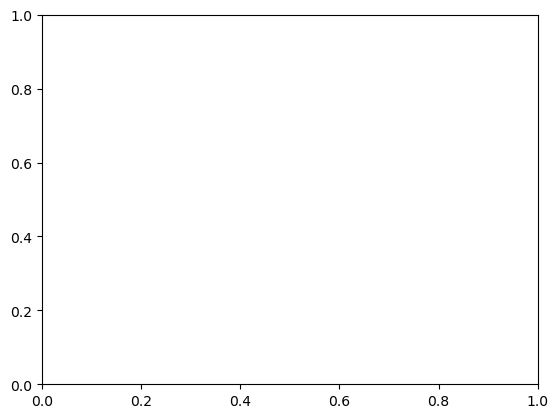

In [6]:
plt.plot(range(1,N_EPOCHS+1), vaegan_trainer.ada_p_log)
plt.plot(range(1,N_EPOCHS+1), vaegan_trainer.valid_losses)
plt.xlabel('Number of epochs')
plt.ylabel('Reconstruction loss')
plt.title('Reconstruction loss mask vae')
plt.legend(['Training set', 'Validation set'])
plot_name = 'RECON_LOSS_'+str(N_EPOCHS) + '_epochs_' + str(Z_DIM) + '_zdim.png'
path = EXPERIMENT_DIR_VAEGAN / plot_name

plt.savefig(path, dpi=200)

In [6]:
BEST_MODEL = Path(r"C:\Users\20182371\Documents\TUe\8DM20_CS_Medical_Imaging\DeepLearning_Project\progress_vaegan\200_epochs_256_zdim_lrlambda")
seed = 0

vaegan_model = VAEGAN(z_dim=Z_DIM, l=2, spade=True).to(device)

model_dir = BEST_MODEL / "model.pth"
vaegan_model.load_state_dict(torch.load(model_dir))
vaegan_model.eval()

patients = [
    path
    for path in DATA_DIR.glob("*")
    if not any(part.startswith(".") for part in path.parts)
]

train_size = 13 

train_indx, valid_indx = train_test_split(patients, random_state=seed, train_size=train_size)

partition = {
    "train": train_indx,
    "validation": valid_indx,
}

training_set = utils.ProstateMRDataset(partition["train"], IMAGE_SIZE, empty_masks = False)
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

first_indx = np.random.choice(np.arange(len(train_loader.dataset)), size=5, replace=False)
second_indx = first_indx+10
for i in range(len(second_indx)):
    if second_indx[i] > len(train_loader.dataset): 
        second_indx[i] = len(train_loader.dataset)-1

first_image_t , first_mask_t = train_loader.dataset[first_indx]
second_image_t, second_mask_t = train_loader.dataset[second_indx]
first_image_t = first_image_t.to(device)
first_mask_t = first_mask_t.to(device)
second_image_t = second_image_t.to(device)
second_mask_t = second_mask_t.to(device)


mu_first, logvar_first = vaegan_model.encoder(first_image_t)
latent_z_first = utils.sample_z(mu_first, logvar_first)
            
mu_second, logvar_second = vaegan_model.encoder(second_image_t)
latent_z_second = utils.sample_z(mu_second, logvar_second)


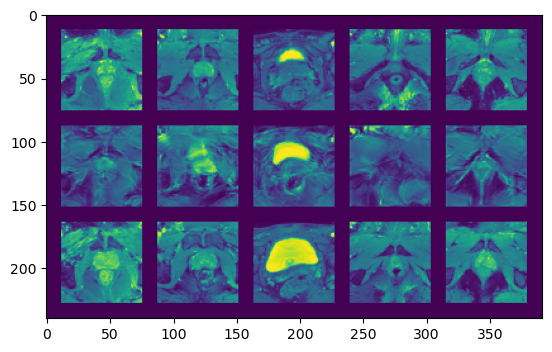

In [16]:
weight = 0.9
gen_latent_z = latent_z_first + weight*(latent_z_second - latent_z_first)
generations  = vaegan_model.generator(gen_latent_z, first_mask_t)

img_grid = make_grid(
                torch.cat([
                    first_image_t.cpu(),
                    generations.cpu(),
                    second_image_t.cpu()
                ]), 
                nrow=5, 
                padding=12, 
                pad_value=-1, )
    
plt.imshow(img_grid.numpy()[0] / 2.0 + 0.5)
plt.imsave(BEST_MODEL / f"interpolated_generations_{weight}.png", img_grid.numpy()[0] / 2.0 + 0.5)

Lossy conversion from float32 to uint8. Range [-0.9769183397293091, 0.9957206845283508]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.9751102924346924, 0.9961746335029602]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.9743328094482422, 0.9961889982223511]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.9715684652328491, 0.9961835741996765]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.966933012008667, 0.9964615106582642]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.9669229984283447, 0.9966106414794922]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.972517192363739, 0.99700504


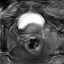

In [12]:
first_indx = np.random.choice(np.arange(len(train_loader.dataset)), size=1, replace=False)
second_indx = first_indx+10

first_image_t , first_mask_t = train_loader.dataset[first_indx]
second_image_t, second_mask_t = train_loader.dataset[second_indx]
first_image_t = first_image_t.to(device)
first_mask_t = first_mask_t.to(device)
second_image_t = second_image_t.to(device)
second_mask_t = second_mask_t.to(device)


mu_first, logvar_first = vaegan_model.encoder(first_image_t)
latent_z_first = utils.sample_z(mu_first, logvar_first)
            
mu_second, logvar_second = vaegan_model.encoder(second_image_t)
latent_z_second = utils.sample_z(mu_second, logvar_second)

images = []
for i in range(0,21,1):
    gen_latent_z = latent_z_first + (i/20)*(latent_z_second - latent_z_first)
    generations  = vaegan_model.generator(gen_latent_z, first_mask_t) 
    
    images.append(np.array(generations.squeeze().detach().cpu()))

    
imageio.mimsave(BEST_MODEL / 'generations.gif', images, fps=10)

#did not know how to display a gif in jupyter notebook so the code below is from ChatGTP 
from IPython.display import HTML
from base64 import b64encode

gif = open(BEST_MODEL / 'generations.gif','rb').read()
#HTML(f"<img src='data:image/gif;base64,{b64encode(gif).decode('utf-8')}' />")
HTML(f"<img src='data:image/gif;base64,{b64encode(gif).decode('utf-8')}' style='width:600px;height:450px;'/>")